<a href="https://colab.research.google.com/github/S1R3S1D/Reinforcement_Learning/blob/main/Bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt


**Bandit Framework**

In [ ]:
class PowerSocket:
  def __init__(self, q):
    self.q = q                  #True Reward
    self.initialize()

  def initialize(self):
    self.n = 0                  #Number of times this socket has been used
    self.Q = 0                  #Estimated value of the charge of this socket

  def charge(self):

    value = np.random.randn()+self.q   #the reward is a guassian distribution with unit variance around the true

    return 0 if value<0 else value

  def update(self, r):
    var = r - self.Q
    self.n+=1
    self.Q = self.Q + (1/self.n)*var

  def sample(self):
    return self.Q               #Returns the estimate of the reward (charge) of the socket


Setting up the Power Sockets

In [ ]:
socket_order = [2, 4, 1 ,3, 5]
sockets = [PowerSocket(q*2+2) for q in socket_order]
n_sockets = len(socket_order)

Plotting the Reward distribution of the power sockets

In [ ]:
steps = 10000
rewards = np.zeros(shape = (steps, n_sockets))

for socket_number, socket in enumerate(sockets):
  for i in range(steps):
    rewards[i, socket_number] = socket.charge()

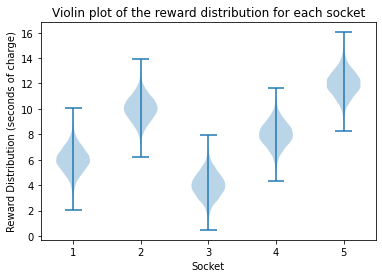

In [ ]:
plt.violinplot(rewards)   
plt.xlabel('Socket')
plt.ylabel('Reward Distribution (seconds of charge)') 
plt.title('Violin plot of the reward distribution for each socket')
plt.show()

Random Argmax Function

In [ ]:
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))

Setting up the Charging Station for testing

In [ ]:
class SocketTestbed():

  def __init__(self, socket = PowerSocket, socket_order = socket_order, multiplier=2):

    self.sockets = [socket(q*multiplier+2) for q in socket_order]


  def chargeAndUpdate(self, socket_i):
    reward = self.socket.charge()
    self.socket.update(reward)

  def selectSocket(self):
    return random_argmax([socket.sample() for socket in self.sockets])

  def run(self, n_steps):
    for i in range(n_steps):
      socket_i = self.selectSocket()
      self.chargeAndUpdate(socket_i)


**Optimistic Greedy Algorithm Experiment**

In [ ]:
class OptimisticPowerSocket( PowerSocket ):
    def __init__(self, q, initial_estimate ):    
        super().__init__(q)
        
        self.Q = initial_estimate                 
        self.n = 1   

In [ ]:
class OGreedySocketTestbed(SocketTestbed):
  def __init__(self, socket = OptimisticPowerSocket, initial_estimate = 20,socket_order = socket_order ):
    self.sockets = [socket(q*2+2, initial_estimate=initial_estimate) for q in socket_order]
    self.rewards = np.zeros(shape=(30, 6))
    self.rando = np.zeros(shape=(1, 5))

  def chargeAndUpdate(self, socket_i):
    reward = self.sockets[socket_i].charge()
    self.sockets[socket_i].update(reward)
    return reward
    

  def selectSocket(self):
    return random_argmax([socket.sample() for socket in self.sockets])

  def run(self, n_steps):
    actual_reward=0
    for i in range(n_steps):
      socket_i = self.selectSocket()
      actual_reward = self.chargeAndUpdate(socket_i)
    return actual_reward
  def init_est(self):
    for i in range(1):
      
      for j in range(5):
        socket = self.sockets[j]
        self.rando[i, j]=socket.sample()

    return self.rando

  def stats(self):
    self.OptimalReward = max([socket.q for socket in self.sockets])
    self.AverageReward = sum([socket.q for socket in self.sockets])/len(self.sockets)
    self.Reward = max([socket.sample() for socket in self.sockets])

    print("Optimal Reward : ",self.OptimalReward )
    print("Average Reward : ",self.AverageReward)
    print("Reward : ",self.Reward)
    print("Array :")
    print(self.rewards)




In [ ]:
ex = OGreedySocketTestbed(initial_estimate=11)


In [ ]:
print(ex.init_est())
ex.run(30)
ex.stats()

In [ ]:
y_vals = []

In [ ]:
for i in range(1, 101):
  v = 0
  for j in range(1000):
    ex = OGreedySocketTestbed(initial_estimate=i)
    v += ex.run(30)/1000
  y_vals.append(v)




In [ ]:
print(y_vals)

[11.289051889596093, 12.348245496343704, 5.734165766623737, 14.591632927482047, 12.889109447153313, 12.566363977020124, 9.681874118371844, 11.728755824851149, 9.92046244030916, 11.912614982842376, 13.733763979476738, 12.554291805240958, 12.703673096441461, 10.97849125791172, 12.521533024261792, 11.586707336772864, 11.582036746542782, 12.980437855086462, 12.79404650169358, 12.387132599101092, 11.420498836477849, 10.723624798881106, 10.489737654795308, 13.277654783883403, 10.542227803988597, 11.928728375784672, 10.008042778875744, 12.02419286434663, 9.717823197022462, 11.320390889084733, 11.186230029681171, 2.313193324696915, 9.995814192902357, 12.995158964836866, 12.447261440900954, 11.147538962506086, 4.503707833972433, 15.145818555618138, 11.353885714292625, 13.381552178009564, 11.694973449593965, 8.623742509427876, 8.682265990796745, 12.61423027804142, 10.516431956796856, 11.814295119729124, 13.335407689068143, 13.047453123211456, 5.143749412544781, 12.322655798168725, 13.31945717459

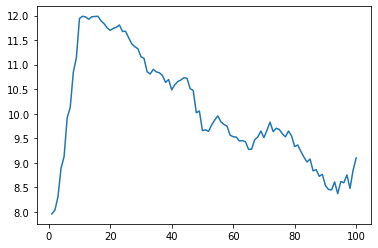

In [ ]:
plt.plot([i for i in range(1, 101)], y_vals)
plt.show()

**ε-Greedy Method**

In [ ]:
class epsilonGreedyTestbed():
  def __init__(self, socket = PowerSocket,socket_order = socket_order,epsilon = 0., multiplier = 2 ):
    self.sockets = [socket(q*multiplier+2) for q in socket_order]
    self.epsilon = epsilon
    self.number_of_sockets = len(self.sockets)

  def chargeAndUpdate(self, socket_i):
    reward = self.sockets[socket_i].charge()
    self.sockets[socket_i].update(reward)
    return reward

  def select_socket( self):
    p = np.random.random()

    if p < self.epsilon:
      socket_index = np.random.choice(self.number_of_sockets)
    else:
      socket_index = random_argmax([socket.sample() for socket in self.sockets])               
        
    return socket_index

  def run(self, n_steps):
    actual_award = 0
    for i in range(n_steps):
      socket_i = self.select_socket()
      actual_award = self.chargeAndUpdate(socket_i)
    return actual_award
  
  def test(self, n_runs):
    avg_reward = 0
    for i in range(n_runs):
      avg_reward += self.run(100)/n_runs
    return avg_reward

       

In [ ]:
rews = []
for i in range(101):
  ex = epsilonGreedyTestbed(epsilon=i/100)
  rews.append(ex.test(1000))

In [ ]:
eps = [ep/100 for ep in range(101)]

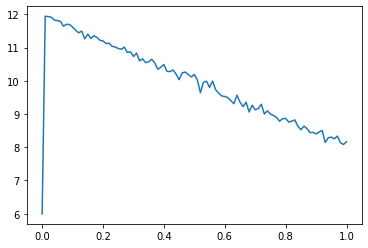

In [ ]:
plt.plot( eps,rews)
plt.show()

**Upper Confidence Bound Algorithm**

In [ ]:
class UCBSocket(PowerSocket):
  def __init__(self, q, confidence_level):
    self.confidence_level = confidence_level
    super(UCBSocket, self).__init__(q)

  def uncertainity(self, t):
    if self.n==0: return float('inf')
    return self.confidence_level * (np.sqrt(np.log(t) / self.n))
  
  def sample(self, t):
    return self.Q + self.uncertainity(t)

In [ ]:
class UCBTestbed():
  def __init__(self, socket=UCBSocket, socket_order=socket_order, multiplier = 2, c=2):
    self.sockets = [socket(q*multiplier+2, confidence_level = c) for q in socket_order]
    self.number_of_sockets = len(self.sockets)

  def chargeAndUpdate(self, socket_i):
    reward = self.sockets[socket_i].charge()
    self.sockets[socket_i].update(reward)
    return reward

  def selectSocket(self, t):
    socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])
    return socket_index

  def run(self, n_steps):
    actual_award = 0
    for i in range(n_steps):
      socket_i = self.selectSocket(i)
      actual_award = self.chargeAndUpdate(socket_i)
    return actual_award
  
  def test(self, n_runs):
    avg_reward = 0
    for i in range(n_runs):
      avg_reward += self.run(100)/n_runs
    return avg_reward
  

In [ ]:
rews=[]
for c in tqdm(range(1, 101)):
  ex = UCBTestbed(c=c)
  rews.append(ex.test(1000))

100%|██████████| 100/100 [06:56<00:00,  4.17s/it]


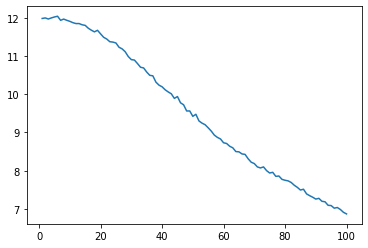

In [ ]:
plt.plot([x for x in range(1, 101)], rews)
plt.show()

Comparing Algorithms

In [ ]:
class OGComp():
  def __init__(self, socket = OptimisticPowerSocket, initial_estimate = 20,socket_order = socket_order, n_steps=200 ):
    self.sockets = [socket(q*2+2, initial_estimate=initial_estimate) for q in socket_order]
    self.rewards = [0]
    self.n_steps = n_steps

  def chargeAndUpdate(self, socket_i):
    reward = self.sockets[socket_i].charge()
    self.sockets[socket_i].update(reward)
    return reward

  def selectSocket(self):
    return random_argmax([socket.sample() for socket in self.sockets])

  def run(self):
    reward = 0
    for i in range(1, self.n_steps+1):
      socket_i = self.selectSocket()
      reward += self.chargeAndUpdate(socket_i)
      self.rewards.append(reward)

  def stats(self):
    return ([i for i in range(self.n_steps+1)], self.rewards)

  
      

In [ ]:
ex = OGComp(initial_estimate=11, n_steps=1000)
ex.run()
(x_og, y_og)=ex.stats()

In [ ]:
class EGComp():
  def __init__(self, socket = PowerSocket,socket_order = socket_order,epsilon = 0., multiplier = 2 ):
    self.sockets = [socket(q*multiplier+2) for q in socket_order]
    self.epsilon = epsilon
    self.number_of_sockets = len(self.sockets)
    self.cum_reward = [0]
  
  def chargeAndUpdate(self, socket_i):
    reward = self.sockets[socket_i].charge()
    self.sockets[socket_i].update(reward)
    return reward

  def select_socket( self):
    p = np.random.random()

    if p < self.epsilon:
      socket_index = np.random.choice(self.number_of_sockets)
    else:
      socket_index = random_argmax([socket.sample() for socket in self.sockets])               
        
    return socket_index

  def run(self, n_steps):
    actual_award = 0
    for i in range(n_steps):
      socket_i = self.select_socket()
      actual_award += self.chargeAndUpdate(socket_i)
      self.cum_reward.append(actual_award)
    return self.cum_reward

  def test(self, n_steps):
    return ([i for i in range(n_steps+1)],self.run(n_steps))


In [ ]:
eex = EGComp(epsilon=0.01)
(x_eg, y_eg) = eex.test(n_steps=1000)

In [ ]:
class UCBComp():
  def __init__(self, socket=UCBSocket, socket_order=socket_order, multiplier = 2, c=2):
    self.sockets = [socket(q*multiplier+2, confidence_level = c) for q in socket_order]
    self.number_of_sockets = len(self.sockets)
    self.cum_reward = [0]

  def chargeAndUpdate(self, socket_i):
    reward = self.sockets[socket_i].charge()
    self.sockets[socket_i].update(reward)
    return reward

  def selectSocket(self, t):
    socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])
    return socket_index

  def run(self, n_steps):
    actual_award = 0
    for i in range(n_steps):
      socket_i = self.selectSocket(i)
      actual_award += self.chargeAndUpdate(socket_i)
      self.cum_reward.append(actual_award)

    return self.cum_reward

  def test(self, n_steps):
    return([x for x in range(n_steps+1)], self.run(n_steps))


In [ ]:
ux = UCBComp()
(x_ucb,y_ucb)=ux.test(1000)

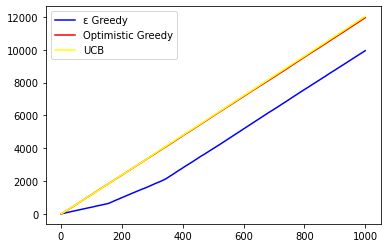

In [ ]:
plt.plot(x_eg, y_eg,color = 'Blue',label="ε Greedy")
plt.plot(x_og, y_og,color = 'Red',label='Optimistic Greedy')
plt.plot(x_ucb, y_ucb, color='Yellow',label="UCB")
plt.legend()
plt.show()